# Задача 1. 

## Описание проекта  и цель

Построить математическую модель стоимости жилья в зависимости от параметров этого жилья.

## Описание данных 

В качестве источника исходных данных предлагается использовать данные сайта магнитогорской недвижимости www.citystar.ru. Данные о недвижимости собраны и загружены в базу данных.  

Столбцы:
 - url - ссылка на объявление 
 - date_app, date_update - даты подачи и обновления объявления
 - note - описание, текст объявления
 - apartment_type - тип недвижимости
 - neighborhood - район
 - street - улица
 - house - дом
 - floor - этаж
 - layout - планировка
 - total_area, living_area, kitchen_area - общая, жилая площади и площадь кухни
 - views - количество просмотров
 - price - целевой признак, цена

## План работы

1. Подготовка данных:
 - Открыть файлы и изучить их. 
 - Посмотреть какие данные можно использовать для обучения модели, произвести предобработку данных.
 - Добавить новые признаки, которые помогут в обучении модели (Feature Engineering).
2. Подготовка к обучению модели
 - Разбиение датафрейма на выборки
 - Проверка мультиколлинеарности признаков и корреляции с таргетом.
 - Выбор моделей для обучения (2-3 модели).
3. Подбор и обучение моделей:
 - Проверка метрики на тесте константной модели.
 - Подбор лучших гиперапараметров моделей на кросс-валидации.
 - Проверка лучшей модели на тестовой выборке.
4. Выводы - отчет.

## 1. Подготовка данных

In [1]:
# Импорт библиотек
import warnings
import re
import datetime
import json
import random
from shutil import rmtree
from joblib import Memory

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import sqlite3
import spacy
import joblib
import lightgbm as lgb
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint as sp_randint

warnings.filterwarnings('ignore')

In [2]:
#Константы
RANDOM_STATE = 42
TEST_SIZE = 0.2

### Откроем файл и изучим его

In [3]:
conn = sqlite3.connect('database.db')

In [4]:
df = pd.io.sql.read_sql('SELECT * FROM base', conn)
df.head()

,url,date_app,date_update,note,apartment_type,neighborhood,street,house,floor,layout,total_area,living_area,kitchen_area,price,views
0,http://citystar.ru/scard.asp?d=43&id=15909831,30.08.2023 15:22:27,02.09.2023 14:03:02,В продаже 4-х комнатная квартира. С хорошим ре...,Трехкомнатная,Орджоникидзевский,Труда,14,8/9,,80.0,53.0,9.0,5999,38
1,http://citystar.ru/scard.asp?d=43&id=15909830,30.08.2023 14:57:57,02.09.2023 14:02:56,Продается 4-х комнатная квартира нестандартной...,Четырехкомнатная,Орджоникидзевский,Труда,18,9/9,,79.0,52.7,8.2,6350,26
2,http://citystar.ru/scard.asp?d=43&id=15927949,02.09.2023 14:02:00,02.09.2023 14:02:21,Продам 3-х комнатную квартиру\r\nпремиум-класс...,Трехкомнатная,Орджоникидзевский,Ленина пр-т,129/2,6/9,,105.0,78.0,14.0,8700,5
3,http://citystar.ru/scard.asp?d=43&id=15927071,02.09.2023 8:11:48,02.09.2023 8:11:48,id:26867. \r\nВНИМАНИЕ! ЭКСКЛЮЗИВНОЕ ПРЕДЛОЖЕН...,Многокомнатная,,Калмыкова,14,8/9,,65.0,45.0,8.0,4800,9
4,http://citystar.ru/scard.asp?d=43&id=15927070,02.09.2023 8:11:47,02.09.2023 8:11:47,id:26185. \r\nП продаже отличная двухкомнатная...,Двухкомнатная,,Суворова,136/1,2/5,,44.3,30.0,6.0,2980,6


In [5]:
# Посмотрим на размеры файла
df.shape

(400, 15)

In [6]:
# Проверка на пропуски
df.isna().sum()

url               0
date_app          0
date_update       0
note              0
apartment_type    0
neighborhood      0
street            0
house             0
floor             0
layout            0
total_area        0
living_area       0
kitchen_area      0
price             0
views             0
dtype: int64

In [7]:
df.iloc[2]['layout']

''

Пропусков нет, но есть значения с пустыми строками.

In [8]:
# Проверка на дубликаты
df.drop(['url', 'date_app', 'date_update', 'views'], axis = 1).duplicated().sum()

3

In [9]:
# Посмотрим на дубликаты
df.loc[df.drop(['url', 'date_app', 'date_update', 'views'], axis = 1).duplicated()]

,url,date_app,date_update,note,apartment_type,neighborhood,street,house,floor,layout,total_area,living_area,kitchen_area,price,views
350,http://citystar.ru/scard.asp?d=43&id=15173851,05.05.2023 10:39:56,05.05.2023 10:39:56,,Двухкомнатная,Правобережный,"Им. газеты ""Правда""",23,4/5,,46.1,29.0,6.0,2600,73
356,http://citystar.ru/scard.asp?d=43&id=15157805,03.05.2023 7:56:17,03.05.2023 7:56:17,id:4253. \r\nВНИМАНИЕ! ЭКСКЛЮЗИВНОЕ ПРЕДЛОЖЕНИ...,Двухкомнатная,правобережный,ул Помяловского,7,4/5,,43.5,27.0,6.0,2650,55
357,http://citystar.ru/scard.asp?d=43&id=15157804,03.05.2023 7:56:17,03.05.2023 7:56:17,id:4252. \r\nВНИМАНИЕ! ЭКСКЛЮЗИВНОЕ ПРЕДЛОЖЕНИ...,Трехкомнатная,Орджоникидзевский,ул Репина,12,1/1,,55.0,39.0,6.0,0,45


In [10]:
# Удалим дубликаты
df = df.drop_duplicates(subset = df.columns[3:-1].to_list())
df.shape

(397, 15)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397 entries, 0 to 399
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   url             397 non-null    object 
 1   date_app        397 non-null    object 
 2   date_update     397 non-null    object 
 3   note            397 non-null    object 
 4   apartment_type  397 non-null    object 
 5   neighborhood    397 non-null    object 
 6   street          397 non-null    object 
 7   house           397 non-null    object 
 8   floor           397 non-null    object 
 9   layout          397 non-null    object 
 10  total_area      397 non-null    float64
 11  living_area     397 non-null    float64
 12  kitchen_area    397 non-null    float64
 13  price           397 non-null    int64  
 14  views           397 non-null    int64  
dtypes: float64(3), int64(2), object(10)
memory usage: 49.6+ KB


Видно, что у столбца floor тип данных указан object. Изменим на int64. 

Так же изменим тип данных у столбцов date_app, date_update - это даты.
У столбца house на int.

#### floor

In [12]:
df['total_floors'] = df['floor'].apply(lambda x: x.split('/')[1])
df['floor'] = df['floor'].apply(lambda x: x.split('/')[0])

In [13]:
df['total_floors'] = df['total_floors'].astype('int64')
df['floor'] = df['floor'].astype('int64')

#### date_app, date_update

In [14]:
# В столбцах с date_app и date_update оставим только дату, без времени и переведем в соответствующий формат
df['date_app'] = pd.to_datetime(df['date_app'].apply(lambda x: x.split()[0]), format='%d.%m.%Y')
df['date_update'] = pd.to_datetime(df['date_update'].apply(lambda x: x.split()[0]), format='%d.%m.%Y')

In [15]:
# Посмотрим на минимальное и максимальное значения столбца
df['date_app'].min(), df['date_app'].max()

(Timestamp('2021-10-25 00:00:00'), Timestamp('2023-09-02 00:00:00'))

In [16]:
# Посмотрим на минимальное и максимальное значения столбца
df['date_update'].min(), df['date_update'].max()

(Timestamp('2023-04-01 00:00:00'), Timestamp('2023-09-02 00:00:00'))

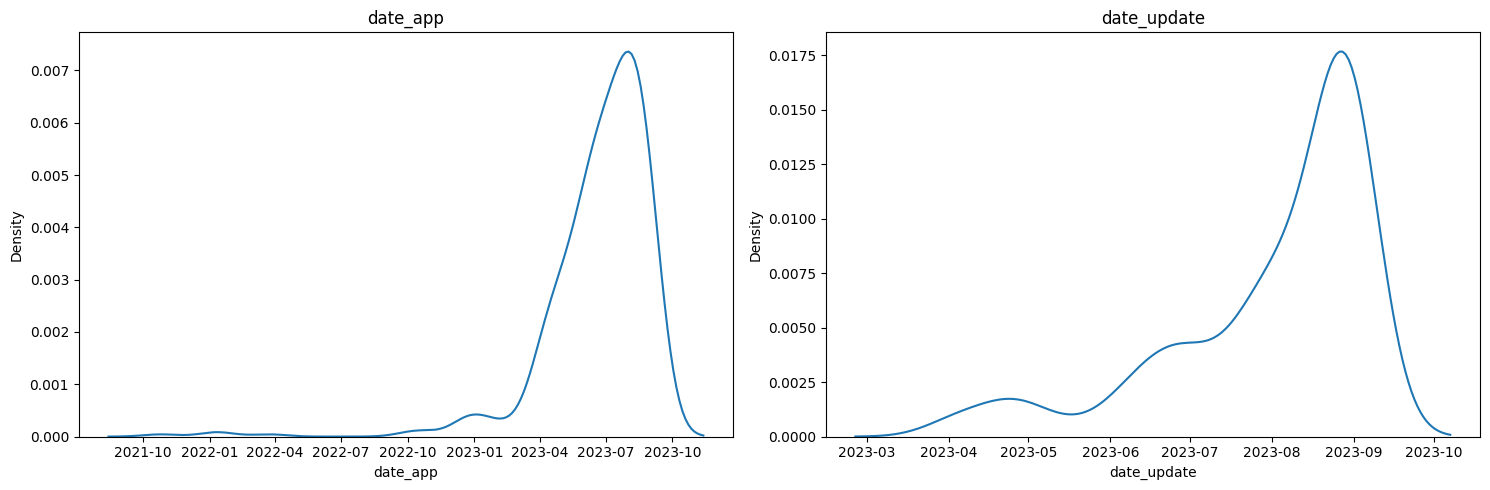

In [17]:
# Посмтроим график плотности в зависимости от дат 
features = ['date_app', 'date_update']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i in range(2):
    sns.kdeplot(data=df, x = features[i], ax=axes[i])
    axes[i].set_title(f'{features[i]}')
plt.tight_layout()
plt.show()

Видно, что представлены объявления о продаже недвижимости за период с октября 2021 года по август 2023. Период обновления (редактирования) представлен с марта 2023 по август 2023г.

Ожидаемо, основная масса объявлений были опубликованы в 2023 году, в период с апреля по август и редактировалась большая часть из них в последний месяц. Т.е. нерелевантных объявлений нет.

#### note

In [18]:
# Определим категориальные переменные
cat_columns = ['url', 'note', 'apartment_type', 'neighborhood', 'street', 'layout']
cat_columns

['url', 'note', 'apartment_type', 'neighborhood', 'street', 'layout']

In [19]:
# Приведем все строковые значения к нижнему регистру
df[cat_columns] = df[cat_columns].apply(lambda row: row.str.lower(), axis = 1)
df.head()

,url,date_app,date_update,note,apartment_type,neighborhood,street,house,floor,layout,total_area,living_area,kitchen_area,price,views,total_floors
0,http://citystar.ru/scard.asp?d=43&id=15909831,2023-08-30,2023-09-02,в продаже 4-х комнатная квартира. с хорошим ре...,трехкомнатная,орджоникидзевский,труда,14,8,,80.0,53.0,9.0,5999,38,9
1,http://citystar.ru/scard.asp?d=43&id=15909830,2023-08-30,2023-09-02,продается 4-х комнатная квартира нестандартной...,четырехкомнатная,орджоникидзевский,труда,18,9,,79.0,52.7,8.2,6350,26,9
2,http://citystar.ru/scard.asp?d=43&id=15927949,2023-09-02,2023-09-02,продам 3-х комнатную квартиру\r\nпремиум-класс...,трехкомнатная,орджоникидзевский,ленина пр-т,129/2,6,,105.0,78.0,14.0,8700,5,9
3,http://citystar.ru/scard.asp?d=43&id=15927071,2023-09-02,2023-09-02,id:26867. \r\nвнимание! эксклюзивное предложен...,многокомнатная,,калмыкова,14,8,,65.0,45.0,8.0,4800,9,9
4,http://citystar.ru/scard.asp?d=43&id=15927070,2023-09-02,2023-09-02,id:26185. \r\nп продаже отличная двухкомнатная...,двухкомнатная,,суворова,136/1,2,,44.3,30.0,6.0,2980,6,5


В данном столбце представлено описание продаваемой недвижимости.

In [20]:
# Посмотрим на произвольное описание
df['note'].iloc[np.random.randint(len(df))]

'3к к. маркса 156, 5/9 кирпичный одноподъездный дом, окна пвх, л/з,  с/у разд, ж/д, натяжные потолки, пластиковые трубы, состояние хорошее, остается кух. гарнитур, мебель.\r\nв собственности с 2011г.'

Такое описание переведем в векторный формат.

#### apartment_type

In [21]:
df['apartment_type'].unique()

array(['трехкомнатная', 'четырехкомнатная', 'многокомнатная',
       'двухкомнатная', 'однокомнатная', ''], dtype=object)

In [22]:
df['apartment_type'].value_counts()

apartment_type
двухкомнатная       141
трехкомнатная       132
однокомнатная        96
четырехкомнатная     17
многокомнатная        6
                      5
Name: count, dtype: int64

Данных нет только в пяти случаях. 

Больше всего в данных представлено 2 и 3-х комнатных квартир, на третьем месте 1-комнатные.

#### neighborhood, street

In [23]:
# Посмотрим на уникальные значения столбца
df['neighborhood'].unique()

array(['орджоникидзевский', '', 'правобережный', 'ленинский',
       'орджоникидзевский (левый берег)', 'правобережный район',
       'ленинский (левый берег)'], dtype=object)

In [24]:
# Посмотрим улицы которые принадлежат правобережному району
df.loc[df['neighborhood'] == 'правобережный район', 'street'].unique()

array(['ул имени газеты правда'], dtype=object)

In [25]:
# Посмотрим улицы которые принадлежат правобережному
df.loc[df['neighborhood'] == 'правобережный', 'street'].unique()

array(['ул суворова', 'грязнова', 'сталеваров', 'карла маркса',
       'завенягина', 'ленина пр-т', 'им. газеты "правда"',
       'ул. суворова 95 к.1', 'советская', 'суворова', 'советской армии',
       'ул. феодосия воронова', 'галиуллина', 'ул грязнова', 'мичурина',
       'советский переулок', 'ул. имени газеты правда',
       'советский переулок 12', 'ул помяловского', 'гагарина',
       'индустриальная'], dtype=object)

Видны опечатки в названии районов, например, правобережный и правобережный район - это один и тот же район.

In [26]:
# Избавимся от опечаток
df.loc[df['neighborhood'] == 'правобережный район', 'neighborhood'] = 'правобережный'

In [27]:
# Посмотрим как часто не указан район
len(df.loc[df['neighborhood'] == ''])

153

Район не указан почти в 40% случаев. Оценим ситуацию с улицами. Для этого названия улиц приведем к единому формату.

In [28]:
# Убираем цифры и лишние символы в названиях улиц
df['street'] = df['street'].apply(lambda x: x.replace('ул ', ''))
df['street'] = df['street'].apply(lambda x: x.replace('ул. ', ''))
df['street'] = df['street'].apply(lambda x: x.replace(' пр-т', ''))
df['street'] = df['street'].apply(lambda x: re.sub(r'[^а-яё\s]', '', x).strip())

In [29]:
# Посмотрим как часто улицы встрчеаются в объявлениях
df.groupby('street')['neighborhood'].agg('count').sort_values(ascending = False)[:10]

street
ленина            60
карла маркса      51
советская         18
зеленый лог       17
труда             15
летия магнитки    11
грязнова          10
курортная          8
московская         7
суворова           7
Name: neighborhood, dtype: int64

Чаще всего продаются квартиры на ул. Ленина, Маркса, Советсткой, Зеленый лог, труда. Возможно, это связано с тем, что проспект Ленина и проспект Карла Маркса - одни из самых протяженных в Магнитогорске.

In [30]:
# Определим наблюдения у которых не заполнено поле street
len(df.loc[df['street'] == ''])

6

In [31]:
# Уникальные знаечния столбца
df['street'].unique()

array(['труда', 'ленина', 'калмыкова', 'суворова', 'ленинградская',
       'сиреневый проезд', 'карла маркса', 'московская', 'ворошилова',
       'грязнова', 'тимирязева', 'западное шоссе', 'сталеваров',
       'тевосяна', 'санаторная', 'металлургов', 'им газеты правда',
       'уральская', 'прпушкина', 'жукова', 'герцена', 'летия магнитки',
       'строителей', 'советская', 'первомайская', 'панькова',
       'российская', 'разина', 'мичурина', 'завенягина', 'куйбышева',
       'коробова', 'октябрьская', 'галиуллина', 'центральная', 'горького',
       'лесная', 'чайковского', 'новая', 'писарева', 'зеленый лог',
       'салтыковащедрина', 'суворова  к', 'бориса ручьева', 'менделеева',
       'имени газеты правда', 'трамвайная', 'пекинская', 'лесопарковая',
       'чапаева', 'советской армии', 'школьная', 'курортная', 'бурденко',
       'набережная', 'феодосия воронова', 'вокзальная', 'чекалина',
       'доменщиков', 'лермонтова', 'фадеева', '', 'тарасенко',
       'черемушки', 'молодежн

#### layout

In [32]:
# Уникальные значения столбца
df['layout'].unique()

array(['', 'старой планировки', 'брежневка', 'сталинский вариант',
       'нестандартная', 'ленинградский проект', 'хрущевка', 'улучшенная',
       'малосемейка', 'полусмежная', 'раздельная', 'свердловский вариант',
       'полустудия', 'гребенка', 'распашонка', 'студия'], dtype=object)

In [33]:
# Оценим как часто встречаются значения в столбце
df['layout'].value_counts()[:10]

layout
                        287
брежневка                22
нестандартная            19
улучшенная               19
старой планировки        16
раздельная               10
хрущевка                  5
сталинский вариант        4
ленинградский проект      3
свердловский вариант      3
Name: count, dtype: int64

Данный признак скорее всего не будет информативным так как почти 3/4 значений не заполнено. Остальные значения встречаются крайне редко.

Так же удалим url - он тоже не информативен

In [34]:
# Удаляем столбцы layout и url
df = df.drop('layout', axis = 1)
df = df.drop('url', axis = 1)

In [35]:
df.drop(['date_app', 'date_update'], axis = 1).describe()

,floor,total_area,living_area,kitchen_area,price,views,total_floors
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,3.727960,57.065315,32.421511,8.686322,3608.176322,57.551637,6.251889
std,2.627852,28.714942,18.106273,3.701445,1629.786433,69.528248,3.570647
min,1.000000,14.100000,0.000000,0.000000,0.000000,5.000000,1.000000
25%,2.000000,42.600000,19.000000,6.000000,2600.000000,24.000000,4.000000
50%,3.000000,52.600000,31.000000,8.000000,3400.000000,42.000000,5.000000
75%,5.000000,65.300000,43.900000,10.000000,4400.000000,70.000000,9.000000
max,14.000000,318.000000,150.000000,35.500000,12750.000000,1022.000000,17.000000


В данным видны аномалии - у которых стоимость равна 0, такие наблюденя лучше исключить из датасета. 

In [36]:
# Убираем объявления с нулевой стоимостью
df = df.loc[df['price'] != 0]

In [37]:
# Проверяем как часто в столбце living_area встречаются нулевые значения
len(df.loc[df['living_area'] == 0])

36

In [38]:
# Проверяем как часто в столбце kitchen_area встречаются нулевые значения
len(df.loc[df['kitchen_area'] == 0])

7

Так же видно, что в 11 случаях не указана площадь кухни, а в 34 случаях не указана жилая площадь. Такие данные тоже лучше исключать из датасета, так как это ошибка или пропуск по сути. Но так как данных мало оставим эти строки.

#### house

In [39]:
# Уникальные значения столбца
len(df['house'].unique())

203

Данный признак слишком вариативен, его невозможно перевести в целочисленный так как есть дома указанные через слэш или дома с литерами, например 129/2 или 36А. Так же удалим этот столбец.

In [40]:
# Удаляем столбец house
df = df.drop('house', axis = 1)

### Добавим новые признаки

Разница между датой подачи и датой обновления объявления может помочь определить, как долго объявление находится в активном состоянии. Это может быть полезным признаком, поскольку более свежие объявления могут быть более актуальными и иметь более высокую цену.

In [41]:
# Возраст объявления
df['age'] = round((datetime.datetime.today() - df['date_app']) / np.timedelta64 ( 1 , 'D'), 2)

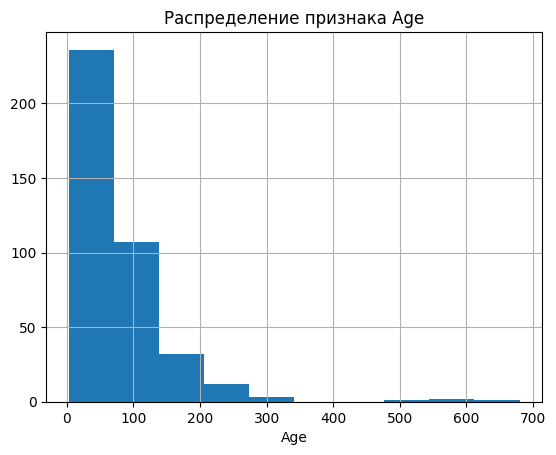

In [42]:
# Оценим распределение признака age
df['age'].hist()
plt.title('Распределение признака Age')
plt.xlabel('Age')
plt.show()

Видно, что большая часть объявлений размещены совсем недавно, около месяца назад. Но есть обявления с возрастом 600-700 дней.

Создадим признаки, которые представляют собой отношение между жилой площадью и общей площадью, а также отношение между площадью кухни и общей площадью. Эти признаки могут помочь учесть пропорции различных зон и их влияние на цену.

In [43]:
# Создаем новые признаки
df['living/total'] = round(df['living_area']/df['total_area'], 2)
df['kitchen/living'] = round(df['kitchen_area']/df['living_area'], 2)

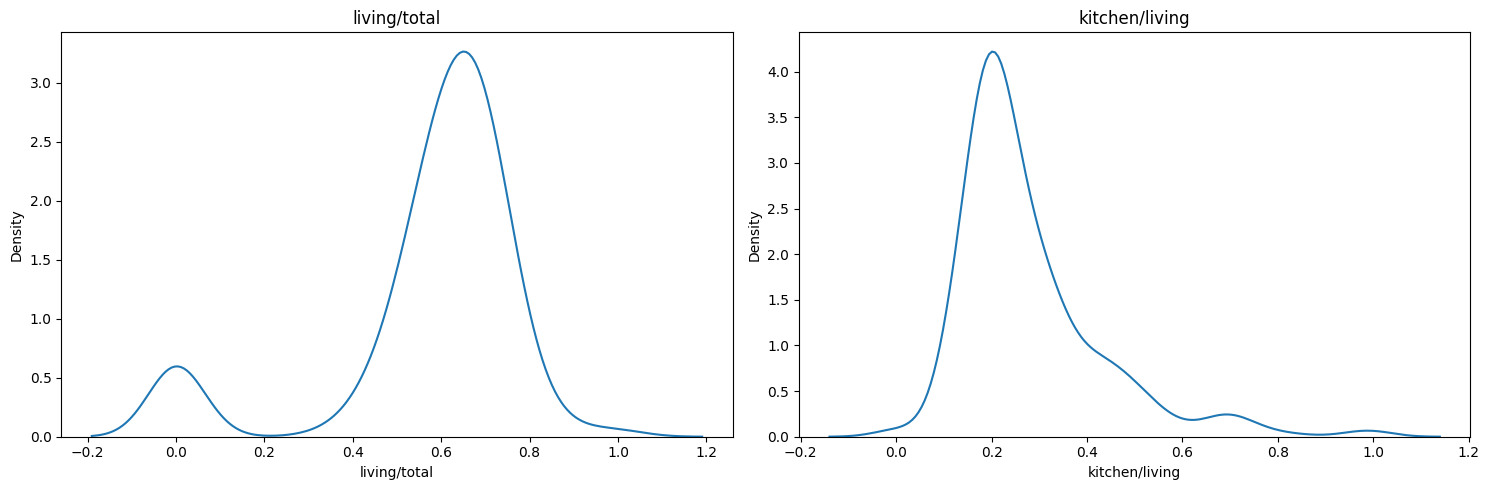

In [44]:
# Посмотрим на графики плотности новых признаков
features = ['living/total', 'kitchen/living']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i in range(2):
    sns.kdeplot(data=df, x = features[i], ax=axes[i])
    axes[i].set_title(f'{features[i]}')
plt.tight_layout()
plt.show()

Видны нулевые значения у обоих признаков. Жилая площадь как правило составляет 60-70% от общей. А площадь кухни составляет 20% от жилой.

In [45]:
df.loc[df['kitchen/living'].isna()].head()

,date_app,date_update,note,apartment_type,neighborhood,street,floor,total_area,living_area,kitchen_area,price,views,total_floors,age,living/total,kitchen/living
221,2023-07-16,2023-09-01,представляем вашему вниманию уютную студию с р...,однокомнатная,,курортная,3,17.5,0.0,0.0,2460,32,4,50.72,0.0,NaN
266,2023-06-27,2023-06-27,id:4836. \r\nв продаже уютная трёхкомнатная кв...,трехкомнатная,,ленина,9,65.2,0.0,0.0,4250,27,9,69.72,0.0,NaN
272,2022-12-23,2023-06-22,id:1182. \r\nпродается теплая полусмежная трех...,трехкомнатная,,труда,1,63.4,0.0,0.0,530,104,2,255.72,0.0,NaN
397,2023-04-01,2023-04-01,"id:2882. \r\n3-х квартира 9/9 этаж, рядом школ...",трехкомнатная,,,5,61.5,0.0,0.0,3700,66,5,156.72,0.0,NaN


In [46]:
# Получившиеся пропуски в данных заменим на 0
df = df.fillna(0)

In [47]:
# np.inf заменим на 999
df.loc[df['kitchen/living']==np.inf, 'kitchen/living'] = 999

Рассчитаем среднее количество просмотров в день, разделив общее количество просмотров на разницу между датой подачи и датой обновления объявления. Это позволит учесть популярность объявления и его влияние на цену

In [48]:
# Создаем новый признак mean_views
df['mean_views'] = round(df['views']/df['age'], 2)

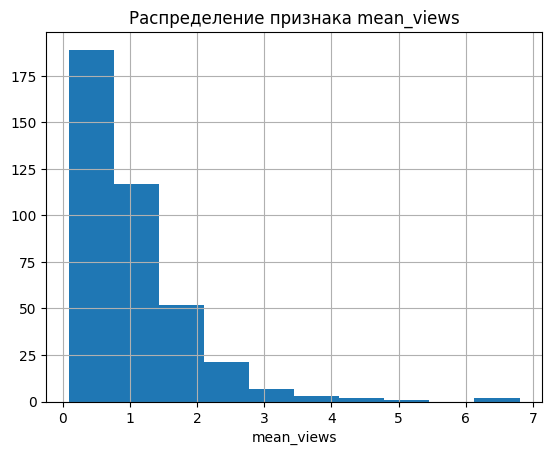

In [49]:
# Оценим распределение признака mean_views
df['mean_views'].hist()
plt.title('Распределение признака mean_views')
plt.xlabel('mean_views')
plt.show()

Медианно значение признака mean_views равняется 0.78, это означает, что объявление просматривают менее одного раза в день. Объявления с количеством просмотров 3 - 7 в день почти не встречаются.

Анализ содержимого столбца "note" позволит извлечь ключевые слова или особенности, которые могут влиять на цену. используем TF-IDF, чтобы векторизовать текстовые данные и создать новые числовые признаки на основе них.

In [50]:
# Посмотрим на длину объявлений
df['len_text'] = df['note'].apply(lambda x: len(x))

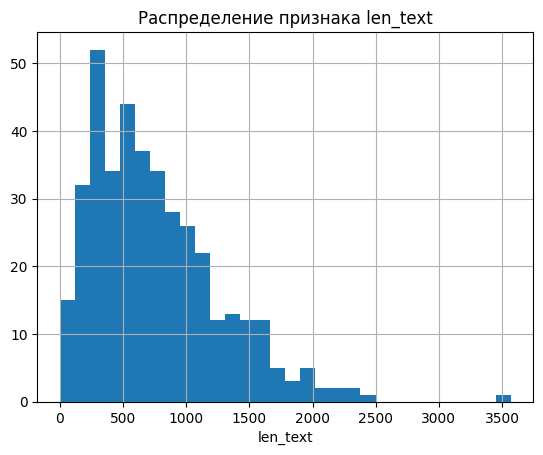

In [51]:
# Оценим распределение признака len_text
df['len_text'].hist(bins = 30)
plt.title('Распределение признака len_text')
plt.xlabel('len_text')
plt.show()

In [52]:
df[df['len_text'] == 0]

,date_app,date_update,note,apartment_type,neighborhood,street,floor,total_area,living_area,kitchen_area,price,views,total_floors,age,living/total,kitchen/living,mean_views,len_text
33,2023-08-31,2023-08-31,,однокомнатная,,жукова,3,40.0,20.0,9.0,3050,8,9,4.72,0.50,0.45,1.69,0
83,2023-08-23,2023-08-23,,двухкомнатная,правобережный,им газеты правда,4,46.1,29.0,6.0,2600,27,5,12.72,0.63,0.21,2.12,0
108,2023-08-14,2023-08-14,,трехкомнатная,орджоникидзевский,труда,6,65.0,43.0,9.0,4980,27,9,21.72,0.66,0.21,1.24,0
195,2023-07-25,2023-08-07,,двухкомнатная,ленинский,набережная,2,60.0,35.0,9.0,4400,26,5,41.72,0.58,0.26,0.62,0


Видно, что объявления как правило включают до 1000 знаков, но есть и пустые объявления. Максимальная длина 3500 знаков.

In [53]:
# Определим модель spacy
model = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])

In [54]:
# Складываем все тексты в один список
texts = df['note'].tolist()

In [55]:
# Лемматизация текста для текстов
res = []
for doc in model.pipe(texts, disable=["tagger", "parser"]):
    try:
        res.append([token.lemma_ for token in doc])
    except:
        print(doc)

In [56]:
# Смотрим на результат - случайным образом сэмплируем несколько примеров
[", ".join(text) for text in random.SystemRandom().sample(res, 3)]

['id:5678, ., \r\n, эксклюзивный, предложение, от, рио, -, люкс, !, !, !, \r\n\xa0\xa0\xa0 , в, продажа, больший, трехкомнатная, квартира, ,, ", хабаровский, ", вариант, ., общий, площадь, квартира, 61, кв., м, ., расположена, на, первый, этаж, пятиэтажный, дом, (, высоко, ), ., окно, на, два, сторона, ., \xa0, весь, комната, раздельный, ., санузел, раздельный, ., дом, блочный, –, очень, тёплый, !, !, !, квартира, светлый, и, тёплый, ,, находиться, в, хороший, и, тихий, место, ,, в, отдаление, от, больший, и, шумный, дорога, ,, тихий, квартал, ,, хороший, и, спокойный, сосед, ., в, квартал, быть, детский, площадка, и, больший, парковка, для, автотранспорт, житель, дом, ., \r\n\xa0\xa0\xa0 , в, квартира, сделать, хороший, ремонт, !, заменить, электропроводка, ,, установить, хороший, пластиковый, окно, ,, решётка, ,, пластиковый, труба, ,, хороший, сантехника, ., по, весь, квартира, натяжной, потолок, с, точечный, светильник, ,, на, пол, хороший, ламинат, 33, класс, ., современный, межко

Удалим знаки препинания, цифры и слова, содержащие цифры. А также иностранные слова, которые не перевелись. Для это соберём регулярное выражение, которое подходит для любого слова, состоящего из букв кирилицы.

In [57]:
# Определим регулярное выражение
word_pattern = re.compile("^[а-яё]*$")

In [58]:
# Определим функцию для очистки текста
def remove_symbols(doc):
    return [token for token in doc if word_pattern.match(token)]

In [59]:
# Очистим текст
corpus = list(map(remove_symbols, res))

In [60]:
# Определим как часто встречаются к корпусе пустые списки (удалены все слова)
corpus_empty = [li for li in corpus if len(li) < 1]
len(corpus_empty)

4

In [61]:
# Смотрим на результат - случайным образом сэмплируем несколько примеров
[", ".join(text) for text in random.SystemRandom().sample(corpus, 3)]

['продаваться, замечательный, светлый, комфортный, раздельный, три, комнатный, квартира, в, центр, магнитогорск, квартира, в, хороший, состояние, окно, выходить, на, разный, сторона, отлично, подойти, для, семья, установить, хороший, пластиковый, окно, стена, и, потолок, выровнять, проводка, заменить, на, пол, в, комната, ламинат, на, кухня, в, коридор, и, санузле, плитка, новый, труба, сантехника, водомер, дверь, межкомнатный, и, входной, заменить, в, квартира, оставаться, мебель, и, техника, вы, мочь, сразу, заехать, и, начать, проживать, рядом, магазин, садик, школа, торговый, центр, парк, бассейн, кафе, ресторан, остановка, хороший, сосед, продажа, в, связь, с, переезд, в, другой, город, квартира, юридически, чистый, возможный, торг',
 'оперативный, показ, по, предварительный, договорённость, продам, просторную, квартира, в, левобережный, часть, город, комната, светлый, раздельный, и, тёплый, уютный, кухня, состояние, заезжай, и, живи, оставаться, мебель, интернет, спутниковый, тар

In [62]:
# Стоп-слова spacy
stopwords_spacy = model.Defaults.stop_words

print(len(stopwords_spacy))

768


Далее векторизируем полученный корпус.

In [63]:
# Посчитаем IDF всех наших слов, и отсечем слова с самым большим idf(очень редкие) и с самым маленьким
tfidf = TfidfVectorizer(stop_words=list(stopwords_spacy), min_df = 10, max_df = 0.9)

In [64]:
# Объединим списки слов в предложения
docs = [" ".join(tokens) for tokens in corpus]
docs[:3]

['в продажа комнатный квартира с хороший ремонт окно выходить на два сторона останься кухонный гарнитура с техника стиральный машинка встроенные шкаф планировка очень удобный квартира отлично подойти для большой семья на выбор много детский сад и развивать центр школа школа искусство камертон торговый центр спортивный центр сквер большой выбор магазин кафе ресторан и многое другое очень удобный транспортный развязка рядом остановка общественный транспорт можно легко и быстро добраться в любой точка город один взрослый собственник квартира проверить обременение нет подходить под ипотека и мат капитал',
 'продаваться комнатный квартира нестандартный планировка в одном из хороший район город дом расположен так что из окно открываться прекрасный вид на город а главный все необходимый для комфортный проживание находиться в шаговый доступность большой выбор детский сад и развивать центр школа школа искусство камертон торговый центр спортивный центр сквер большой выбор магазин кафе ресторан и

In [65]:
# Трансформируем корпус
x = tfidf.fit_transform(docs)

In [66]:
# Проверим размерность
x.shape

(394, 426)

In [67]:
# Посмотрим на результат векторизации
x = pd.DataFrame(x.toarray(), columns = tfidf.get_feature_names_out())
pd.DataFrame(x)

,абзаково,агентство,адрес,аптека,база,балкон,банк,банный,безупречный,белый,...,экологически,эксклюзивный,электричество,электропроводка,электросчётчик,этаж,этажный,юг,южный,юридический
0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
1,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
2,0.0,0.000000,0.0,0.059800,0.0,0.049758,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
3,0.0,0.110076,0.0,0.066727,0.0,0.000000,0.000000,0.0,0.110076,0.0,...,0.111493,0.107442,0.0,0.000000,0.0,0.000000,0.098871,0.0,0.0,0.087666
4,0.0,0.000000,0.0,0.000000,0.0,0.140015,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,0.0,0.000000,0.0,0.116996,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.188385,0.0,0.167292,0.0,0.000000,0.000000,0.0,0.0,0.000000
390,0.0,0.000000,0.0,0.000000,0.0,0.085276,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
391,0.0,0.000000,0.0,0.000000,0.0,0.168220,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.192307,0.000000,0.0,0.0,0.000000
392,0.0,0.000000,0.0,0.106451,0.0,0.088575,0.180253,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.101259,0.000000,0.0,0.0,0.279712


Уменьшим признаковое пространство при помощи PCA, оставим 5 компонент. 

In [68]:
# Определяем PCA c 5-ю компонентами
pca = PCA(n_components=5)
x = pca.fit_transform(x)
x

array([[ 0.03073232, -0.1639761 , -0.00761696,  0.02704625, -0.17552159],
       [-0.00242319, -0.16168202, -0.07954799, -0.13559357, -0.09090453],
       [ 0.00402194, -0.18979791, -0.12380783, -0.27113698, -0.05565641],
       ...,
       [-0.08501353,  0.11822557, -0.00837823,  0.00957668, -0.12372179],
       [ 0.16392008, -0.13321385,  0.11496365,  0.03194926, -0.04969328],
       [ 0.09167926,  0.00717903,  0.02176492, -0.09494116, -0.14537287]])

In [69]:
# Добавим новые признаки в исходный датафрейм
df = pd.concat([df.reset_index(drop = True), pd.DataFrame(x, columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5'])], axis = 1)
df.shape

(394, 23)

In [70]:
# Удалим столбец note и посмотрм на размер итоговый датасет
df = df.drop(['note'], axis = 1)
# , 'date_app', 'date_update'
df.shape

(394, 22)

Изучены данные о продаже квратир с сайта магнитогорской недвижимости www.citystar.ru.

Собран датасет, который включает в себя 397 наблюдений (после удаления дубликатов) и 15 столбцов, в том числе целевой признак - цену недвижимости. Пропусков в данных нет, но есть поля, содержащие пустые строки.

Признаки приведены к правильным типам данных и предобработаны:
Удалены неинформативные признаки: url (ссылка на объявление), house(дом), layout(планировка)

Видно, что в данных представлены объявления о продаже недвижимости за период с октября 2021 года по август 2023. Период после обновления объявления (редактирования) представлен с марта 2023 по август 2023г.
Ожидаемо, основная масса объявлений были опубликованы в 2023 году, в период с апреля по август и редактировалась большая часть из них в последний месяц. Т.е. нерелевантных объявлений нет.

Исправлены отпечатки в названиях районов. Район не указан почти в 40% случаев. 
Чаще всего продаются квартиры на ул. Ленина, Маркса, Советсткой, Зеленый лог, труда. Возможно, это связано с тем, что проспект Ленина и проспект Карла Маркса - одни из самых протяженных в Магнитогорске. Отсутствуют названия улиц в 6 случаях.

Больше всего в данных представлено 2 и 3-х комнатных квартир, на третьем месте 1-комнатные.

Удалены наблюдения со стоимость равной 0 (аномалии). 

В датасет добавлены новые признаки:
 - возраст объявления age
 - living/total и kitchen/living - признаки показывающие соотношение (планировку) между разными типами площадей
 - среднее количество просмотров в день
 - векторное представление столбца note - после лемматизации и очистки текстов от цифр, знаков препинания и пр. приведен в векторный формат при помощи tf-idf. В итоге получена матрица размерности (394, 426). С учетом небольшого количества данных такое признаковое пространство может приводить к проблемам при обучении модели. Поэтому размерность матрицы после tf-idf снижена при помощи метода главных компонент PCA с количеством компонент = 5.

при оценке соотношений между разными типами площадей видно, что жилая площадь как правило составляет 60-70% от общей. А площадь кухни составляет 20% от жилой.
Медианно значение признака mean_views равняется 0.78, это означает, что объявление просматривают менее одного раза в день. Объявления с количеством просмотров 3 - 7 в день почти не встречаются.
Видно, что объявления как правило включают до 1000 знаков, но есть и пустые объявления. Максимальная длина 3500 знаков.

После объединения данных размер датафрейма стал (394, 22)

## 2. Подготовка к обучению модели

### Разобьем данные на выборки

In [71]:
# Разобьем данные на выборки
X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis = 1), 
                                        df['price'], test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [72]:
# Проверка правильности разбиения на выборки
len(df) == len(X_train) + len(X_test)

True

### Проверка мультиколлинеарности признаков и корреляции с таргетом.

In [73]:
# Определим количественные переменные
numeric = X_train.select_dtypes(include=[np.number]).columns.to_list()

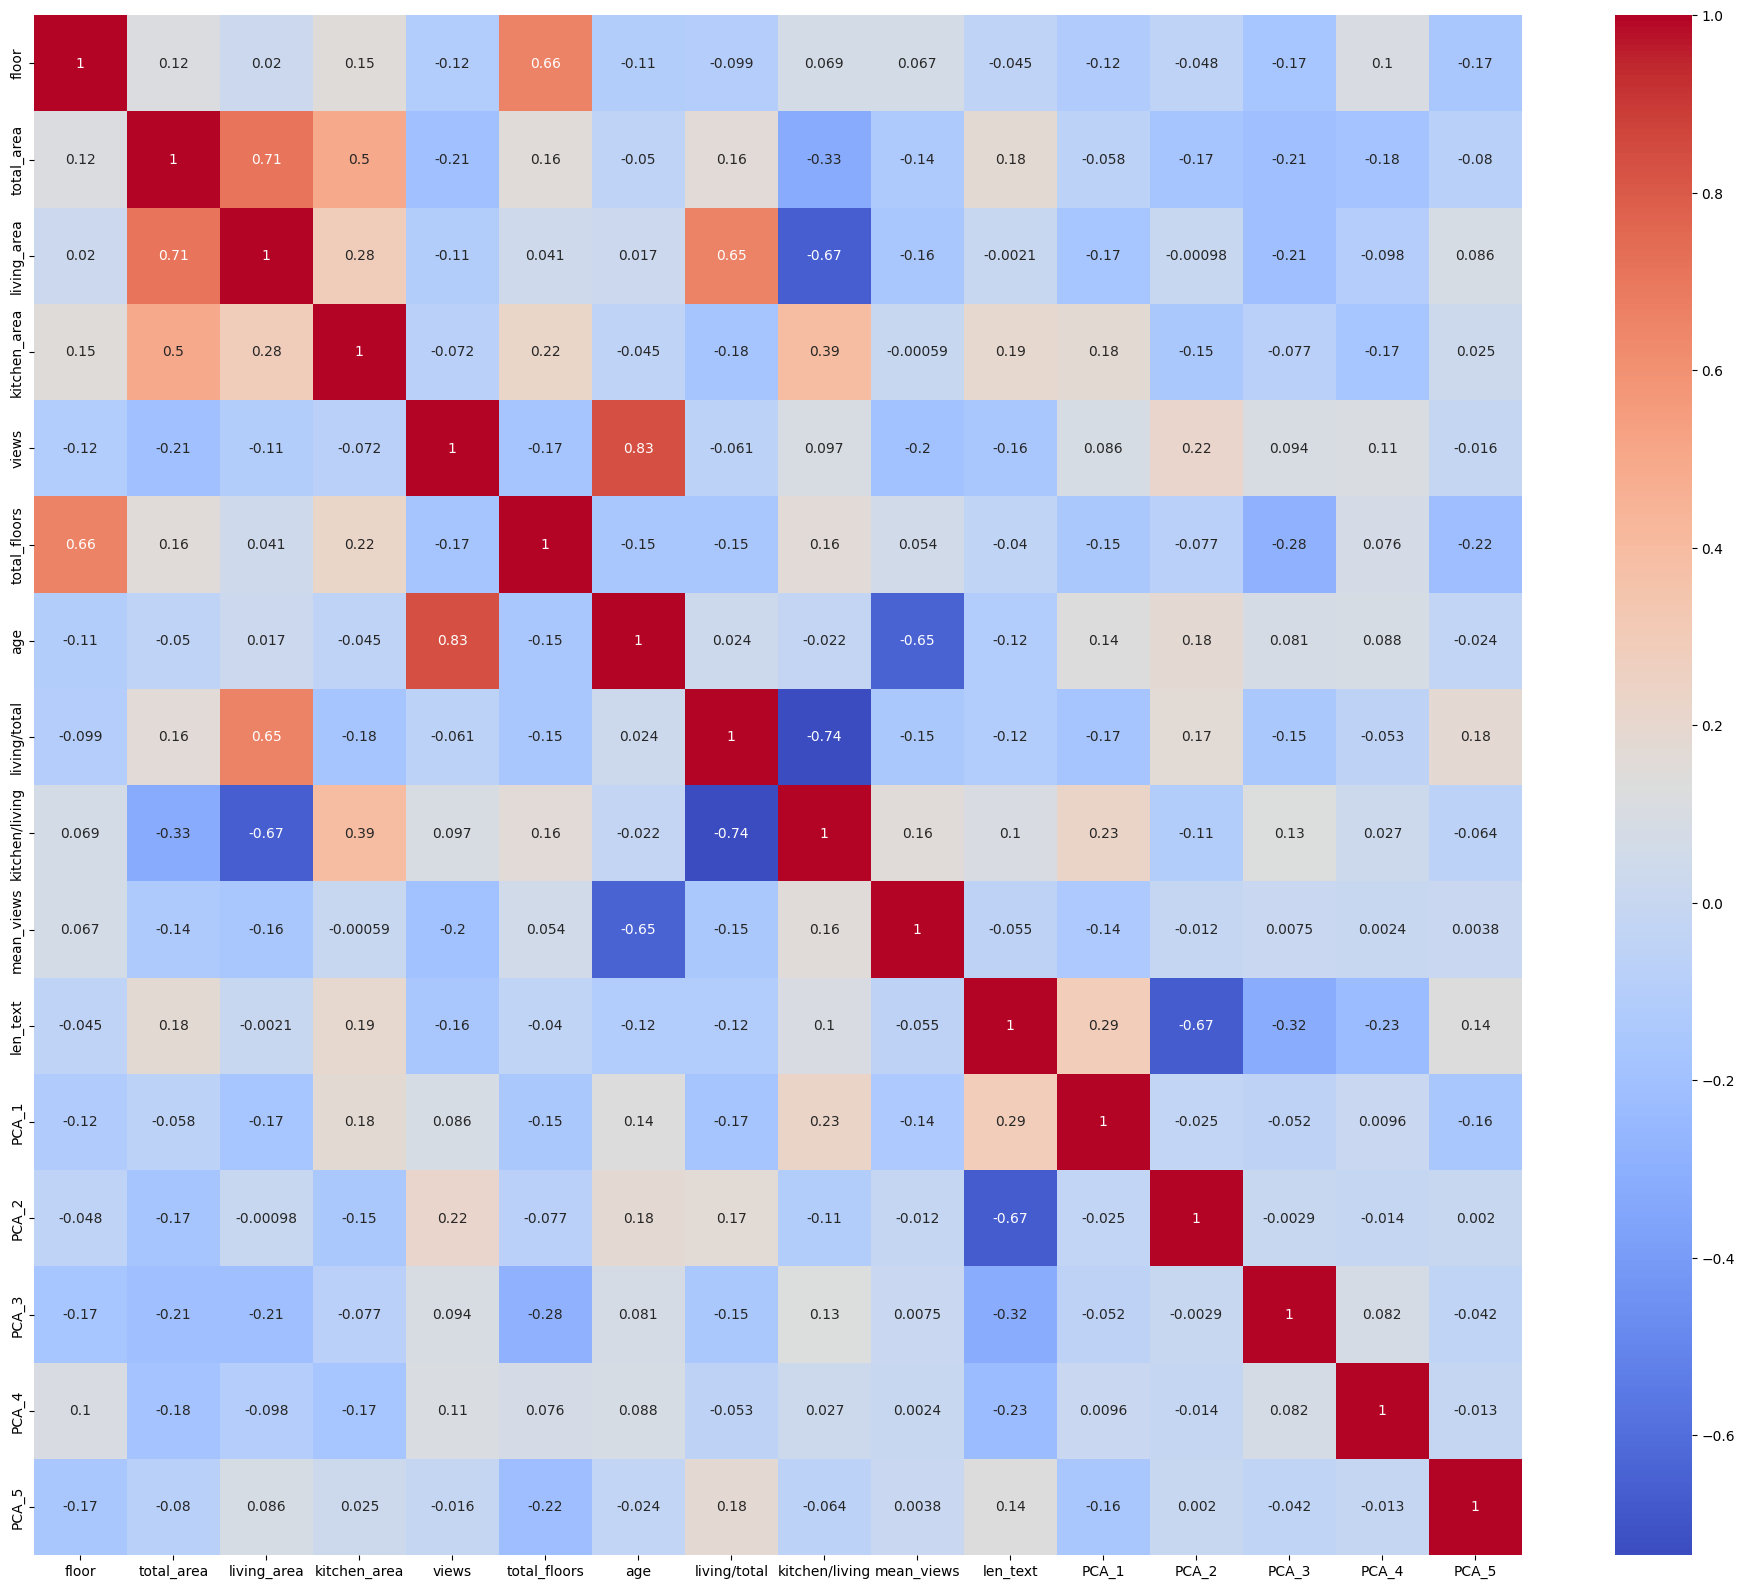

In [74]:
#Проверим есть ли корреляция между данными в разных столбцах
plt.figure(figsize=(24,20))
correlation_matrix = X_train[numeric].corr(method = 'spearman')
sns.heatmap(correlation_matrix, annot = True, cmap='coolwarm')
plt.show()

В данных есть признаки с высокой корреляцией:
 - total_area - living_area (0.71)
 - living_area - kitchen/living (0.76)
 - views - age (0.83)
 - kitchen/living - living/total (0.79)
 - PCA_2 - len_text (-0.67)
 - mean_views - age (-0.67)

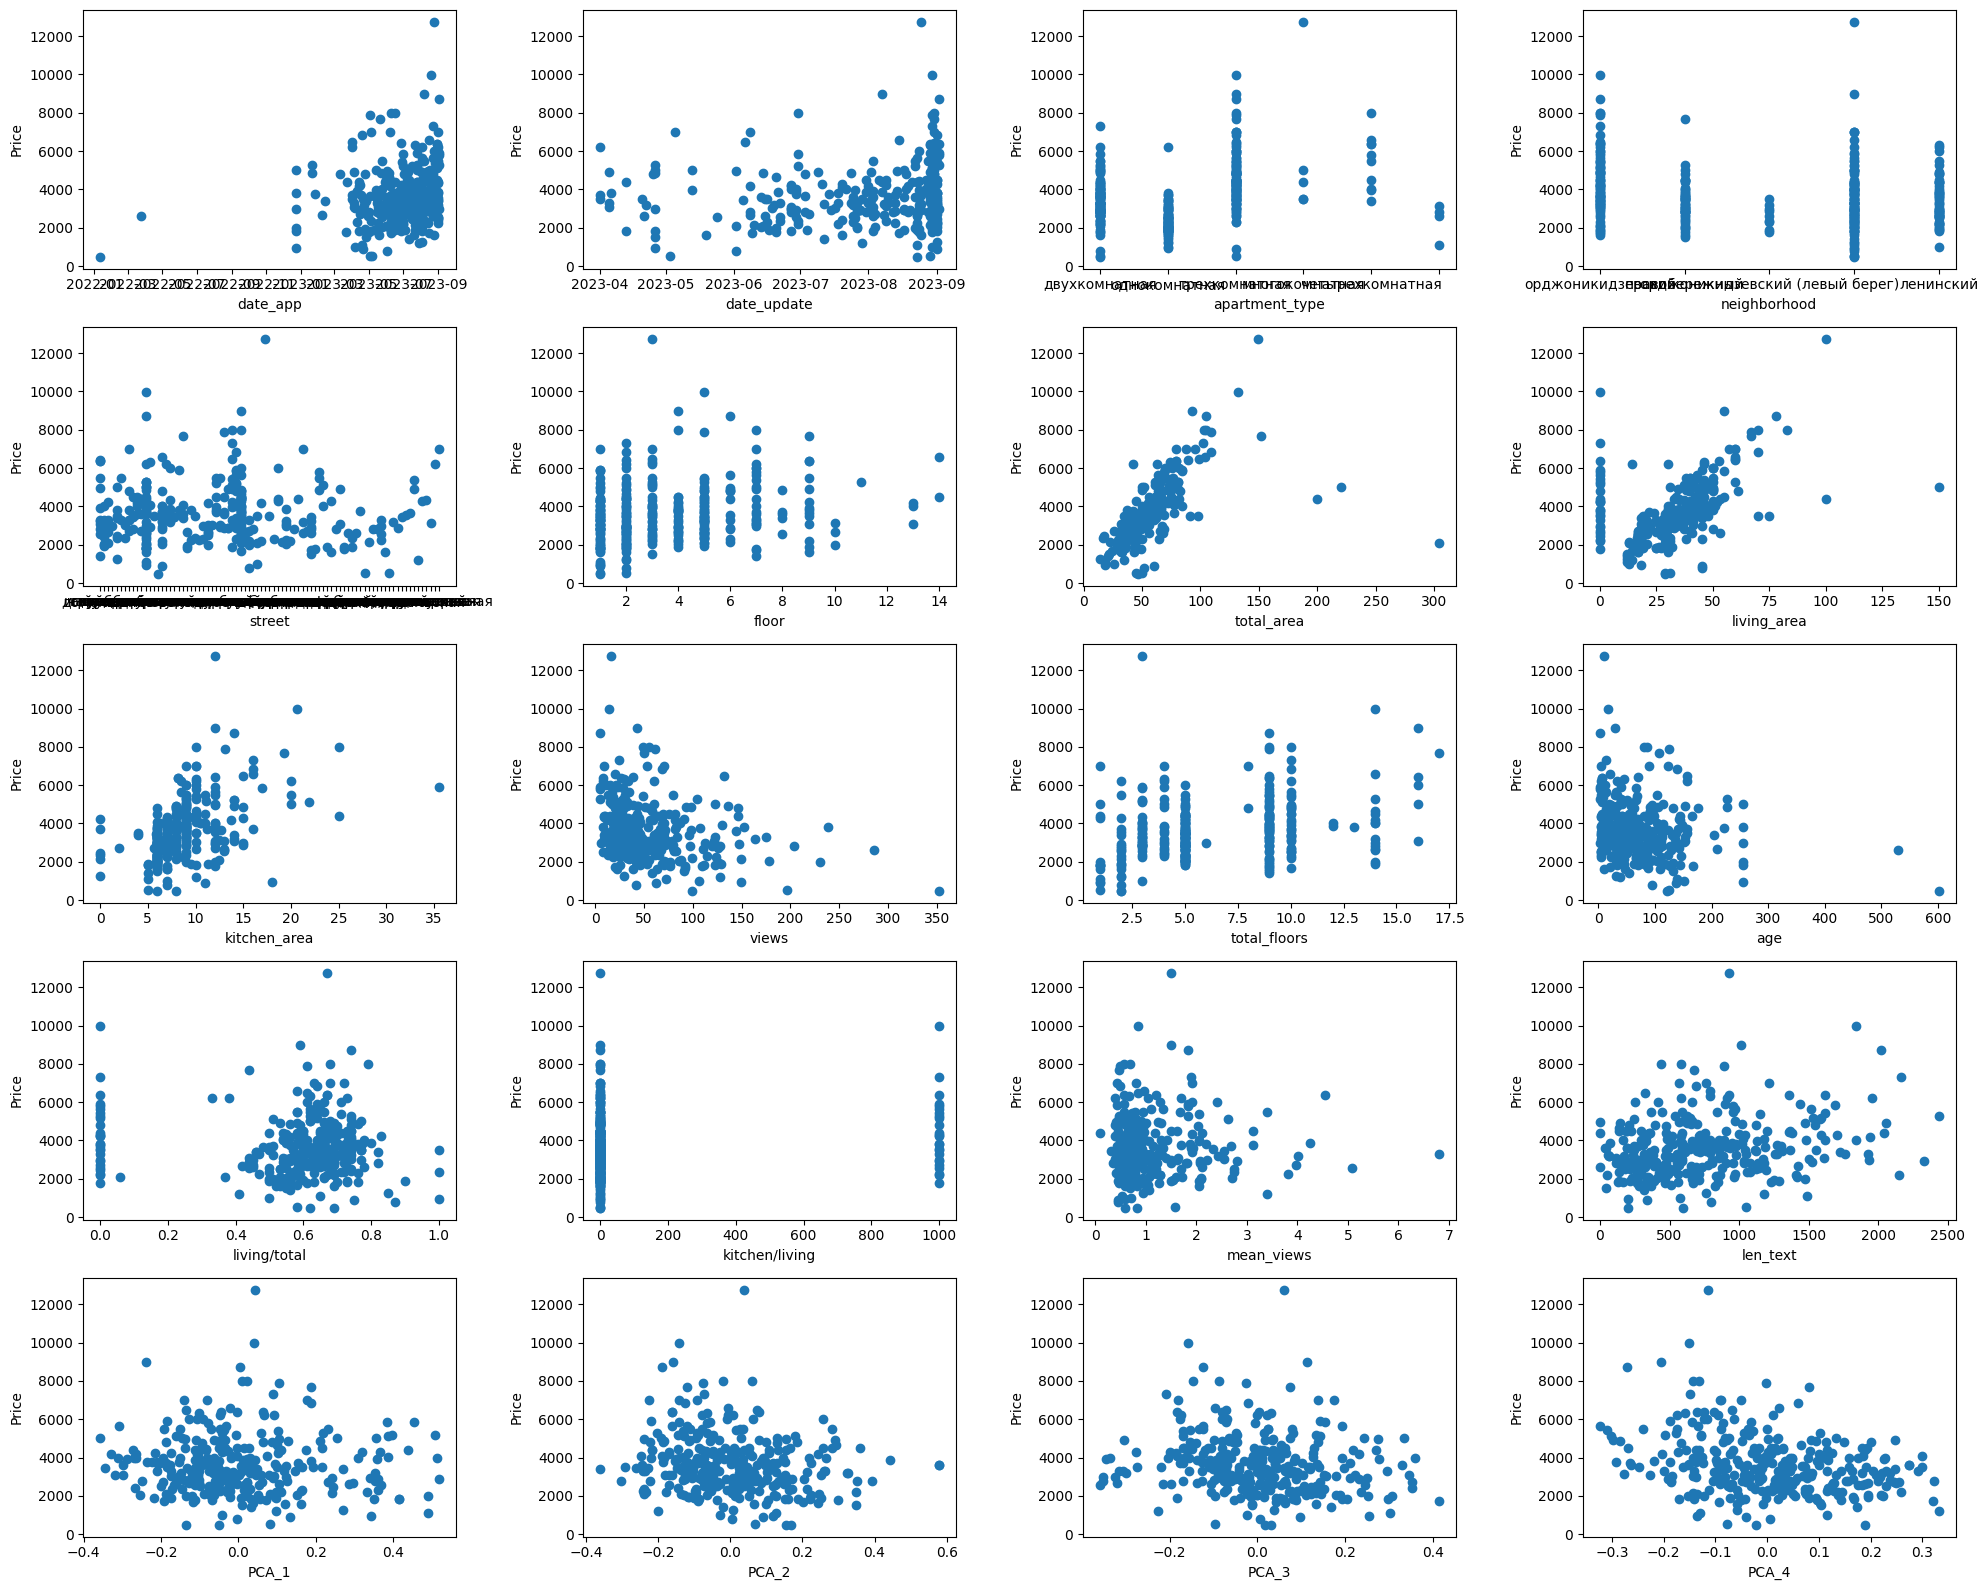

In [75]:
# Оценим взаимосвязи между признаками и target.
fig, ax = plt.subplots(5, 4, figsize=(20, 16))

count = 0
for i in range(5):
    for j in range(4):
        ax[i, j].scatter(X_train.iloc[:, count], y_train)
        ax[i, j].set_xlabel(f'{X_train.columns[count]}')
        ax[i, j].set_ylabel('Price')
        count += 1
plt.tight_layout()
plt.show()

При оценке влияния признаков на целевой признак отмечено, что тип недвижимости влияет на стоимость. Так видно, что однокомнатный квартиры обычно дешевле двухкомнатных, а трехкомнатные дороже двухкомнатных.
Четырехкомнатных квартир немного и они не выходят по стоимости за пределы трехкомнатных. 

При анализе влияния района нахождения квартиры на стоимость выявлено, что самые дешевые квартиры находятся в Оржоникидзевский (левый берег), но их представлено не много, затем Правобережный, Ленинский и  самый дорогой Оржоникидзевский.

Квартиры 1, 2 и 3 этажей как правило дороже тех, что на 4 или 5.

Почти прямая зависимость с ценой у признака total_area - площадь квартиры и признака living_area. Площадь кухни kitchen_area показывает меньшую зависимость.

### Выбор моделей для обучения (2-3 модели)

При оценке влияния признаков на целевой признак отмечено, что тип недвижимости влияет на стоимость. Так видно, что однокомнатный квартиры обычно дешевле двухкомнатных, а трехкомнатные дороже двухкомнатных.
Четырехкомнатных квартир немного и они не выходят по стоимости за пределы трехкомнатных. 

При анализе влияния района нахождения квартиры на стоимость выявлено, что самые дешевые квартиры находятся в Оржоникидзевский (левый берег), но их представлено не много, затем Правобережный, Ленинский и  самый дорогой Оржоникидзевский.

Квартиры 1, 2 и 3 этажей как правило дороже тех, что на 4 или 5.

Почти прямая зависимость с ценой у признака total_area - площадь квартиры и признака living_area. Площадь кухни kitchen_area показывает меньшую зависимость.

По матрице корреляций видно, что высокие показатели корреляции Спирмена (~ 0.7) корреляции у:
 - total_area - living_area (0.71)
 - living_area - kitchen/living (0.76)
 - views - age (0.83)
 - kitchen/living - living/total (0.79)
 - PCA_2 - len_text (-0.67)
 - mean_views - age (-0.67)
 
Для пространства признаков, в котором есть мультиколлинеарные признаки, подходят модели, которые устойчивы к мультиколлинеарности и имеют методы выбора признаков, такие как регуляризация (например, L1 или L2-регуляризация), чтобы уменьшить влияние коррелированных признаков и избежать переобучения модели.

С учетом наличия категориальных признаков, таких как street и neighborhood и малого количества данных (не хочется увеличивать пространство признаков при OHE-кодировании), будем использовать модели на основе деревьев решений, так как они не нуждаются в масштабировании данных. Категориальные переменные закодируем Ordinal Encoding. 

Поэтому для обучения будем использовать модели:

 - Random Forest
 - LGBMRegressor

## 3.  Подбор и обучение моделей

### Проверка метрики на тесте константной модели.

Так как в задании не указана метрика для оценки модели, будем использовать MAE. Эта метрика измеряет среднюю абсолютную разницу между прогнозируемыми и фактическими значениями стоимости недвижимости. Она более устойчива к выбросам и может быть полезной в случае наличия выбросов в данных.

In [76]:
#Посчитаем MAE наивного регрессора
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

print(f' MAE наивного регрессора {round(mean_absolute_error(y_test, dummy_regr.predict(X_test)), 2)}')

 MAE наивного регрессора 1316.05


### Подбор моделей и их гиперпараметров на кросс-валидации.

In [77]:
categorical_features = ['neighborhood', 'street', 'apartment_type']

In [78]:
location = "cachedir"
memory = Memory(location=location, verbose=0)

#   Для категориальных - применяем OrdinalEncoder
data_transformer = ColumnTransformer(transformers=[
    ("categorical", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features),
])

pipeline = make_pipeline(
                         data_transformer,  
                         'passthrough', 
                         memory=memory)

In [79]:
pipeline

Pipeline(memory=Memory(location=cachedir\joblib),
         steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['neighborhood', 'street',
                                                   'apartment_type'])])),
                ('passthrough', 'passthrough')])

In [80]:
param_grid = [{
    'passthrough': [RandomForestRegressor()],
    'passthrough__random_state' : [RANDOM_STATE],
    'passthrough__max_depth': sp_randint (2, 14),
    'passthrough__n_estimators': sp_randint (50, 300),
    'passthrough__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
},{
    'passthrough': [lgb.LGBMRegressor()],
    'passthrough__random_state': [RANDOM_STATE],
    'passthrough__learning_rate': stats.uniform(0.0001, 0.5),
    'passthrough__max_depth': sp_randint (2, 14),
    'passthrough__n_estimators': sp_randint (50, 300),
    'passthrough__objective' : ['regression', 'regression_l1', None],
    'passthrough__num_leaves' : sp_randint (5, 50)
}
]

search = RandomizedSearchCV(pipeline, param_grid, n_jobs=-1, verbose=0, error_score='raise',
                            scoring = 'neg_mean_absolute_error')

search.fit(X_train, y_train)

memory.clear(warn=False)
rmtree(location)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59
[LightGBM] [Info] Number of data points in the train set: 315, number of used features: 3
[LightGBM] [Info] Start training from score 3450.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [81]:
# Лучший оценщик 
model = search.best_estimator_[1]
model

LGBMRegressor(learning_rate=0.11664706804070947, max_depth=13, n_estimators=218,
              num_leaves=24, objective='regression_l1', random_state=42)

In [104]:
model.n_features_in_

3

In [82]:
# Лучшие параметры модели из перебора
search.best_params_

{'passthrough': LGBMRegressor(learning_rate=0.11664706804070947, max_depth=13, n_estimators=218,
               num_leaves=24, objective='regression_l1', random_state=42),
 'passthrough__learning_rate': 0.11664706804070947,
 'passthrough__max_depth': 13,
 'passthrough__n_estimators': 218,
 'passthrough__num_leaves': 24,
 'passthrough__objective': 'regression_l1',
 'passthrough__random_state': 42}

In [83]:
# Лучшие параметры модели из перебора
abs(search.best_score_)

879.7301489271492

In [84]:
# Сохраним модель
joblib.dump(model, 'best_model.pkl')

['best_model.pkl']

### Проверка лучшей модели на тестовой выборке.

In [85]:
print(f' MAE на тестовой выборке составляет {round(mean_absolute_error(y_test, search.best_estimator_.predict(X_test)), 2)}')

 MAE на тестовой выборке составляет 939.94


## 4.  Выводы

**1. Подготовка данных**

Изучены данные о продаже квратир с сайта магнитогорской недвижимости www.citystar.ru.

Собран датасет, который включает в себя 397 наблюдений (после удаления дубликатов) и 15 столбцов, в том числе целевой признак - цену недвижимости. Пропусков в данных нет, но есть поля, содержащие пустые строки.

Признаки приведены к правильным типам данных и предобработаны:
Удалены неинформативные признаки: url (ссылка на объявление), house(дом), layout(планировка).

Видно, что в данных представлены объявления о продаже недвижимости за период с октября 2021 года по август 2023. Период после обновления объявления (редактирования) представлен с марта 2023 по август 2023г.
Ожидаемо, основная масса объявлений были опубликованы в 2023 году, в период с апреля по август и редактировалась большая часть из них в последний месяц. Т.е. нерелевантных объявлений нет.

Исправлены отпечатки в названиях районов. Район не указан почти в 40% случаев. 
Чаще всего продаются квартиры на ул. Ленина, Маркса, Советсткой, Зеленый лог, труда. Возможно, это связано с тем, что проспект Ленина и проспект Карла Маркса - одни из самых протяженных в Магнитогорске. Отсутствуют названия улиц в 6 случаях.

Больше всего в данных представлено 2 и 3-х комнатных квартир, на третьем месте 1-комнатные.

Удалены наблюдения со стоимость равной 0 (аномалии). 

В датасет добавлены новые признаки:
 - возраст объявления age
 - living/total и kitchen/living - признаки показывающие соотношение (планировку) между разными типами площадей
 - среднее количество просмотров в день
 - векторное представление столбца note - после лемматизации и очистки текстов от цифр, знаков препинания и пр. приведен в векторный формат при помощи tf-idf. В итоге получена матрица размерности (394, 426). С учетом небольшого количества данных такое признаковое пространство может приводить к проблемам при обучении модели. Поэтому размерность матрицы после tf-idf снижена при помощи метода главных компонент PCA с количеством компонент = 5.

При оценке соотношений между разными типами площадей видно, что жилая площадь как правило составляет 60-70% от общей. А площадь кухни составляет 20% от жилой.
Медианно значение признака mean_views равняется 0.78, это означает, что объявление просматривают менее одного раза в день. Объявления с количеством просмотров 3 - 7 в день почти не встречаются.
Видно, что объявления как правило включают до 1000 знаков, но есть и пустые объявления. Максимальная длина 3500 знаков.

После предобработки и добавления новых признаков размер датафрейма стал (394, 22).

**2. Подготовка к обучению модели**

При оценке влияния признаков на целевой признак отмечено, что тип недвижимости влияет на стоимость. Так видно, что однокомнатный квартиры обычно дешевле двухкомнатных, а трехкомнатные дороже двухкомнатных.
Четырехкомнатных квартир немного и они не выходят по стоимости за пределы трехкомнатных. 

При анализе влияния района нахождения квартиры на стоимость выявлено, что самые дешевые квартиры находятся в Оржоникидзевский (левый берег), но их представлено не много, затем Правобережный, Ленинский и  самый дорогой Оржоникидзевский.

Квартиры 1, 2 и 3 этажей как правило дороже тех, что на 4 или 5.

Почти прямая зависимость с ценой у признака total_area - площадь квартиры и признака living_area. Площадь кухни kitchen_area показывает меньшую зависимость.

По матрице корреляций видно, что высокие показатели корреляции Спирмена (~ 0.7) корреляции у:
 - total_area - living_area (0.71)
 - living_area - kitchen/living (0.76)
 - views - age (0.83)
 - kitchen/living - living/total (0.79)
 - PCA_2 - len_text (-0.67)
 - mean_views - age (-0.67)
 
Для пространства признаков, в котором есть мультиколлинеарные признаки, подходят модели, которые устойчивы к мультиколлинеарности и имеют методы выбора признаков, такие как регуляризация (например, L1 или L2-регуляризация), чтобы уменьшить влияние коррелированных признаков и избежать переобучения модели.

С учетом наличия категориальных признаков, таких как street и neighborhood и малого количества данных (не хочется увеличивать пространство признаков при OHE-кодировании), будем использовать модели на основе деревьев решений, так как они не нуждаются в масштабировании данных. Категориальные переменные закодируем Ordinal Encoding. 

Поэтому для обучения будем использовать модели:

 - Random Forest
 - LGBMRegressor

**3. Подбор и обучение моделей**

MAE наивного регрессора, который для всех наблюдений предсказывает среднее значение составляет 1316.05.

Подбор лучших гиперпараметров осуществлялся при помощи RandomizedSearchCV.

Лучшая модель - LGBMRegressor, MAE для best_estimator_ составляет 879.73 на кросс-валидации. Лучшие результаты для остальных моделей представлены в таблице.


| Модель | среднее MAE на кроссвалидации | Место в итоговой таблице |
|----------|----------|----------|
| LGBMRegressor    | 879.73 | 1 |
| RandomForestRegressor    | 891.70 | 5 |


Лучшая модель была проверена на тестовой выборке, ее результат составляет 939.94

**Что можно сделать еще:**

 - Данных недостаточно - спарсить еще, чтобы модели было проще находить закономерности в данных.
 - Добавить еще признаки, например, по адресу восстановить широту и долготу.
 - Проанализировать ошибки модели - посмотреть на чем она ошибается.

# Задача 2. 

## Описание проекта  и цель

На основе данных собранных в задании 1 разбить исходную выборку на кластеры методами кластерного анализа. Цель задания определить  район продажи квартиры на основе данных о ценах, площадях и количестве комнат. Сравнить полученный результат с реальным расположением квартир по районам. В качестве района рассматривать Ленинский, Орджоникидзевский, Правобережный, Орджоникидзевский (Левый берег) и Ленинский (левый берег).


In [111]:
# Импорт библиотек
from sklearn.cluster import KMeans

In [116]:
# Создадим датафрейм для кластеризации, исключим пропущенные нулевые значения
data = df[['price', 'apartment_type', 'total_area', 'living_area', 'kitchen_area', 'neighborhood']]

data = data.loc[data['living_area'] != 0]
data = data.loc[data['kitchen_area'] != 0]

In [117]:
# Заменим значение в столбце apartment_type на число, соответствующее количеству комнат и удалим наблюдения с 0.
apartment_type_dict = {
    'однокомнатная' : 1,
    'двухкомнатная' : 2,
    'трехкомнатная' : 3,
    'четырехкомнатная' : 4,
    'многокомнатная' : 5,
    '' : 0
}

data['apartment_type'] = data['apartment_type'].apply(lambda x: apartment_type_dict[x])

data = data.loc[data['apartment_type'] != 0]
data['apartment_type'].unique()

array([3, 4, 5, 2, 1], dtype=int64)

In [120]:
# Оставим только те строки для которых указан район
data = data.loc[data['neighborhood'] != '']

Районов представлено 5, но попробуем подобрать оптимальное количество кластеров.

In [121]:
# Подбираем количество кластеров
K = range(4, 20)
Sum_of_squared_distances = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data.drop('neighborhood', axis = 1))
    Sum_of_squared_distances.append(kmeans.inertia_)

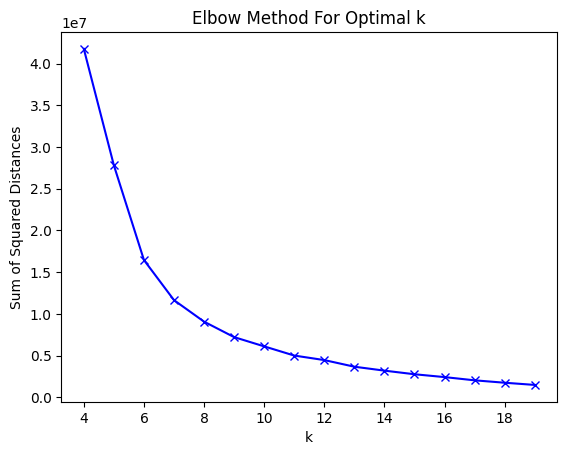

In [122]:
# Рисуем график метода локтя
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [151]:
# Разобьем данные на 7 кластеров
kmeans = KMeans(n_clusters = 7)
data["cluster"] = kmeans.fit_predict(data.drop('neighborhood', axis = 1))
data["cluster"] = data["cluster"].astype("int")
data.head()

,price,apartment_type,total_area,living_area,kitchen_area,neighborhood,cluster
0,5999,3,80.0,53.0,9.0,орджоникидзевский,3
1,6350,4,79.0,52.7,8.2,орджоникидзевский,3
2,8700,3,105.0,78.0,14.0,орджоникидзевский,2
5,3350,3,50.8,36.0,6.0,правобережный,5
10,3010,3,55.4,41.0,6.0,ленинский,1


In [152]:
# Добавим новый признак - номер кластера
data["cluster"].value_counts()

cluster
5    53
1    48
4    41
0    33
6    24
3    12
2     6
Name: count, dtype: int64

In [153]:
# Посмотрим как часто встречаются различные районы
data["neighborhood"].value_counts()

neighborhood
орджоникидзевский                  83
ленинский                          63
правобережный                      59
орджоникидзевский (левый берег)    11
ленинский (левый берег)             1
Name: count, dtype: int64

Видно, что на левом берегу(орджоникидзевский (левый берег) и ленинский (левый берег)) расположено всего 12 наблюдений, у которых указан район.

На правом берегу(орджоникидзевский, ленинский, правобережный) наблюдений больше и алгоритм должен разделять их точнее.

In [137]:
# Посмотрим какие номера кластеров определились для каждого района
data.loc[data['neighborhood'] == 'орджоникидзевский', 'cluster'].value_counts()

cluster
0    28
2    24
1    14
4    12
3     5
Name: count, dtype: int64

In [138]:
# Посмотрим какие номера кластеров определились для каждого района
data.loc[data['neighborhood'] == 'правобережный', 'cluster'].value_counts()

cluster
0    32
1    14
2    12
3     1
Name: count, dtype: int64

In [139]:
# Посмотрим какие номера кластеров определились для каждого района
data.loc[data['neighborhood'] == 'ленинский', 'cluster'].value_counts()

cluster
0    23
1    19
2    16
4     5
Name: count, dtype: int64

In [140]:
# Посмотрим какие номера кластеров определились для каждого района
data.loc[data['neighborhood'] == 'орджоникидзевский (левый берег)', 'cluster'].value_counts()

cluster
1    6
0    5
Name: count, dtype: int64

In [141]:
# Посмотрим какие номера кластеров определились для каждого района
data.loc[data['neighborhood'] == 'ленинский (левый берег)', 'cluster'].value_counts()

cluster
1    1
Name: count, dtype: int64

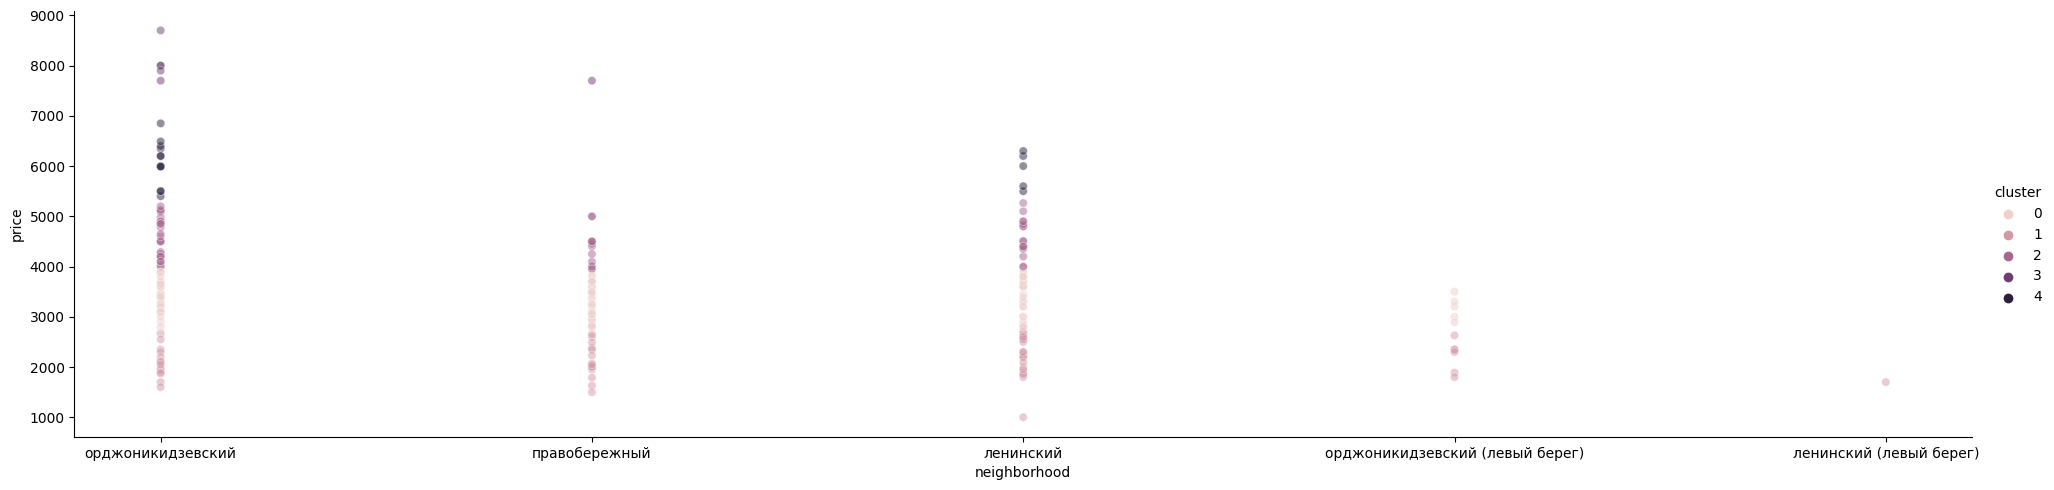

In [146]:
# Посмотрим как реально разделились данные по кластерам
g = sns.relplot(
    data=data,
    x='neighborhood',
    
    y='price',
    
    hue='cluster',
    kind="scatter",
    aspect=4,
    alpha=0.5,
);

Видно, что алгоритм не очень хорошо разделил наблюдения на кластеры в сравнении с реальными районами.

Наблюдений на левом берегу не так много (12) и им алгоритм присвоил метки кластеров 1 и 0.

Квартиры на правом берегу разделились чуть лучше (всего 205 квартир).
 - орджоникидзевский район наиболее соответствует 0, 2, 1, 4 кластерам
 - правобережный - 0, 1, 2
 - ленинский - 0, 1, 2

Так как в действительности районы расположены рядом, это нормально, что у них пересекаются номера кластеров.
На графике результатов кластерного анализа видно, что квартиры с высокой стоимостью алгоритм относит к орджоникидзевскому или ленинскому районам.

Что можно сделать лучше:
 - добавить новые характеристики для проведения кластерного анализа.
 - применить другие алгоритмы кластеризации 

In [154]:
conn.close()

In [155]:
! pip freeze > requirements.txt